In [1]:
from bs4 import BeautifulSoup
# import pandas as pd
from datetime import datetime, timedelta
from itertools import combinations
import json
import requests
import math
from typing import Optional, List, Dict
import os

from pydantic import BaseModel
from typing import Mapping
import numpy as np
import polars as pl
import hvplot.polars
import pandas as pd
import altair as alt
import math

from shared.utils import formalize_data_with_str
from shared.random_rules import RandomRules

In [2]:
rr = RandomRules(
  TOTAL_NUMBERS = 50,
  CHOOSE = 6,
  MAX_PRIMES = 3,
  N_VALUES=["1", "2", "3"],
  # Rangos de valores de las bolillas
  MIN_B_VALUES = [1, 2, 3, 4, 5, 6],
  MAX_B_VALUES = [45, 46, 47, 48, 49, 50]
)

In [3]:
url = 'https://resultados.latinka.com.pe/i.do?m=historico&t=0&s=41'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

tables = soup.select('table')
rows = tables[1].find_all('tr')

In [4]:
lst = []
post_str_b1 = None
post_str_b2 = None
post_str_b3 = None
post_str_b4 = None
post_str_b5 = None
post_str_blast = None
for row in rows:
  cols = [data.text.strip() for data in row.find_all('td')]
  
  id, bolillas_int, str_combo = formalize_data_with_str(bolillas_str=cols[2])
  cols.append(id)
  cols.append(bolillas_int)
  cols.extend([b for b in bolillas_int])
  cols.extend(str_combo)
  cols.append(post_str_b1)
  cols.append(post_str_b2)
  cols.append(post_str_b3)
  cols.append(post_str_b4)
  cols.append(post_str_b5)
  cols.append(post_str_blast)

  is_rare, reason = rr.is_rare_combination(bolillas_int, id)
  cols.append(is_rare)
  cols.append(reason)

  cols.append(rr.jumps_map(bolillas_int))
  cols.append(rr.unijump(bolillas_int))
  
  lst.append(cols)

  post_str_b1 = str_combo[0]
  post_str_b2 = str_combo[1]
  post_str_b3 = str_combo[2]
  post_str_b4 = str_combo[3]
  post_str_b5 = str_combo[4]
  post_str_blast = str_combo[-1]

with open('./gn_tnk_v3.json', 'w') as file: 
  json.dump(lst, file)

dfRows = pl.DataFrame(
  lst,
  schema=[
    'fecha', 'sorteo', 'bolillas', 'yapa', 'adicionales', 'sorteo_extra',
    'id', 'combo', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
    'str_b1', 'str_b2', 'str_b3', 'str_b4', 'str_b5', 'str_b6',
    'post_str_b1', 'post_str_b2', 'post_str_b3', 'post_str_b4', 'post_str_b5', 'post_str_blast',
    'is_rare_combination', 'reason',
    "jumps_map", "unijump"
  ],
  schema_overrides={
    'combo': pl.Array(pl.UInt8, 6),
    'b1': pl.UInt8,
    'b2': pl.UInt8,
    'b3': pl.UInt8,
    'b4': pl.UInt8,
    'b5': pl.UInt8,
    'b6': pl.UInt8,
    'reason': pl.UInt8
  },
  orient='row'
)

TOTAL_LINES = len(dfRows)
print(f'{TOTAL_LINES=}')
display(dfRows.head(10))
dfRows.write_parquet('dfrows_tnk.parquet')

TOTAL_LINES=2492


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""09/07/2025""","""1210""","""35 28 09 42 31 16""","""45""","""50 23""","""Promoción Sí o Sí""","""091628313542""","[9, 16, … 42]",9,16,28,31,35,42,"""09""","""16""","""28""","""31""","""35""","""42""",null,null,null,null,null,null,false,0,"""07_12_03_04_07""",-32
"""06/07/2025""","""1209""","""29 20 14 11 03 15""","""35""","""12 33 37""","""Promoción Sí o Sí""","""031114152029""","[3, 11, … 29]",3,11,14,15,20,29,"""03""","""11""","""14""","""15""","""20""","""29""","""09""","""16""","""28""","""31""","""35""","""42""",false,0,"""08_03_01_05_09""",-9
"""02/07/2025""","""1208""","""14 28 32 07 10 29""","""36""","""37 27 16""","""Promoción Sí o Sí""","""071014282932""","[7, 10, … 32]",7,10,14,28,29,32,"""07""","""10""","""14""","""28""","""29""","""32""","""03""","""11""","""14""","""15""","""20""","""29""",false,0,"""03_04_14_01_03""",70
"""29/06/2025""","""1207""","""47 37 32 22 24 23""","""04""","""20 39 09""","""Promoción Sí o Sí""","""222324323747""","[22, 23, … 47]",22,23,24,32,37,47,"""22""","""23""","""24""","""32""","""37""","""47""","""07""","""10""","""14""","""28""","""29""","""32""",true,24,"""01_01_08_05_10""",35
"""25/06/2025""","""1206""","""38 30 08 27 48 14""","""17""","""18""","""Promoción Sí o Sí""","""081427303848""","[8, 14, … 48]",8,14,27,30,38,48,"""08""","""14""","""27""","""30""","""38""","""48""","""22""","""23""","""24""","""32""","""37""","""47""",false,0,"""06_13_03_08_10""",-50
"""22/06/2025""","""1205""","""07 45 25 33 02 46""","""22""","""27 44""","""Promoción Sí o Sí""","""020725334546""","[2, 7, … 46]",2,7,25,33,45,46,"""02""","""07""","""25""","""33""","""45""","""46""","""08""","""14""","""27""","""30""","""38""","""48""",true,16,"""05_18_08_12_01""",-66
"""18/06/2025""","""1204""","""26 45 28 09 24 50""","""14""","""07""","""Promoción Sí o Sí""","""092426284550""","[9, 24, … 50]",9,24,26,28,45,50,"""09""","""24""","""26""","""28""","""45""","""50""","""02""","""07""","""25""","""33""","""45""","""46""",true,24,"""15_02_02_17_05""",-44
"""15/06/2025""","""1203""","""41 24 42 34 29 44""","""26""","""08 30 39""","""Promoción Sí o Sí""","""242934414244""","[24, 29, … 44]",24,29,34,41,42,44,"""24""","""29""","""34""","""41""","""42""","""44""","""09""","""24""","""26""","""28""","""45""","""50""",true,8,"""05_05_07_01_02""",25
"""11/06/2025""","""1202""","""22 39 20 19 38 15""","""32""","""13 35 25""","""Promoción Sí o Sí""","""151920223839""","[15, 19, … 39]",15,19,20,22,38,39,"""15""","""19""","""20""","""22""","""38""","""39""","""24""","""29""","""34""","""41""","""42""","""44""",false,0,"""04_01_02_16_01""",-51


In [5]:
dfRows.item(0, 'b2')

16

In [6]:
import holoviews as hv
def plot_post_col (col: str, post_col: str, test_value: str | None = None):
  if test_value == None:
    test_value = dfRows.item(0, col)
    print(f'Setting {test_value=}')

  df_viz = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .group_by(
      post_col
    ).agg(pl.count(post_col).alias('count')) \
    .sort("count", descending=True)
  
  
  df_10_last = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .head(10)
  
  # Agrega una columna que sea el porcentaje de la frecuencia relativa
  total = df_viz['count'].sum()
  df_viz = df_viz.with_columns(
    ( (pl.col('count') / total) * 100 ).alias('percent')
  )

  mean_percent = df_viz['percent'].mean()
  mean_percent_75 = mean_percent * 75 / 50
  mean_percent_25 = mean_percent * 25 / 50

  chart = df_viz.hvplot.bar(
    x=post_col,
    y='percent'
  )

  chart = chart * hv.HLine(mean_percent).opts(color='red')
  chart = chart * hv.HLine(mean_percent_75).opts(color='blue')
  chart = chart * hv.HLine(mean_percent_25).opts(color='blue')
  
  chart.opts(default_tools=["pan"])

  df_jumps_map = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .group_by(
      'jumps_map'
    ).agg(pl.count('jumps_map').alias('count')) \
    .sort("count", descending=True)
  
  df_unijump = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .group_by(
      'unijump'
    ).agg(pl.count('unijump').alias('count')) \
    .sort("count", descending=True)


  print(f'df_viz FOR {col} = {test_value}')
  display(df_viz)

  display(chart)
  

  print(f'df_10_last FOR {col} = {test_value}')
  last_results = list(set(df_10_last[post_col][0:3]))
  print(f'Last 3 results {last_results=}')
  display(df_10_last)
  
  print(f'df_jumps_map FOR {col} = {test_value}')
  display(df_jumps_map)
  # display(df_unijump)

  print(f'df_unijump FOR {col} = {test_value}')
  display(df_unijump)

  lst_post_str_b = df_viz.filter(pl.col('percent') >= mean_percent)[post_col].to_list()
  lst_jumps_map = df_jumps_map['jumps_map'].to_list() # Used to discard
  
  return lst_post_str_b, lst_jumps_map, last_results

In [7]:
possible_b1, exclude_jump_maps_b1, last_post_b1 = plot_post_col(col='str_b1', post_col='post_str_b1')

Setting test_value='09'
df_viz FOR str_b1 = 09


post_str_b1,count,percent
str,u32,f64
"""01""",18,15.652174
"""02""",15,13.043478
"""06""",12,10.434783
"""04""",10,8.695652
"""05""",9,7.826087
…,…,…
"""19""",2,1.73913
"""10""",1,0.869565
"""21""",1,0.869565


:Overlay
   .Bars.I    :Bars   [post_str_b1]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b1 = 09
Last 3 results last_results=['02', '07']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""18/06/2025""","""1204""","""26 45 28 09 24 50""","""14""","""07""","""Promoción Sí o Sí""","""092426284550""","[9, 24, … 50]",9,24,26,28,45,50,"""09""","""24""","""26""","""28""","""45""","""50""","""02""","""07""","""25""","""33""","""45""","""46""",true,24,"""15_02_02_17_05""",-44
"""18/05/2025""","""1195""","""11 13 42 09 33 15""","""46""","""12""","""Promoción Sí o Sí""","""091113153342""","[9, 11, … 42]",9,11,13,15,33,42,"""09""","""11""","""13""","""15""","""33""","""42""","""07""","""11""","""24""","""34""","""36""","""45""",true,8,"""02_02_02_18_09""",-57
"""04/05/2025""","""1191""","""09 35 19 15 37 10""","""46""","""25 02 38""","""Promoción Sí o Sí""","""091015193537""","[9, 10, … 37]",9,10,15,19,35,37,"""09""","""10""","""15""","""19""","""35""","""37""","""02""","""33""","""35""","""38""","""48""","""50""",true,16,"""01_05_04_16_02""",-57
"""23/04/2025""","""1188""","""22 16 20 33 35 09""","""46""","""24""","""Promoción Sí o Sí""","""091620223335""","[9, 16, … 35]",9,16,20,22,33,35,"""09""","""16""","""20""","""22""","""33""","""35""","""07""","""08""","""21""","""33""","""41""","""46""",false,0,"""07_04_02_11_02""",-39
"""02/03/2025""","""1173""","""39 09 28 46 18 44""","""15""","""30 04 14""","""Promoción Sí o Sí""","""091828394446""","[9, 18, … 46]",9,18,28,39,44,46,"""09""","""18""","""28""","""39""","""44""","""46""","""01""","""03""","""12""","""28""","""32""","""47""",false,0,"""09_10_11_05_02""",17
"""01/01/2025""","""1156""","""33 24 09 38 22 46""","""15""","""""","""""","""092224333846""","[9, 22, … 46]",9,22,24,33,38,46,"""09""","""22""","""24""","""33""","""38""","""46""","""13""","""18""","""22""","""35""","""45""","""49""",true,16,"""13_02_09_05_08""",47
"""01/12/2024""","""1147""","""42 09 27 12 35 15""","""13""","""48 43 03 08""","""Promoción Sí o Sí""","""091215273542""","[9, 12, … 42]",9,12,15,27,35,42,"""09""","""12""","""15""","""27""","""35""","""42""","""02""","""17""","""20""","""29""","""36""","""38""",true,8,"""03_03_12_08_07""",38
"""13/11/2024""","""1142""","""49 19 35 09 17 18""","""45""","""34""","""Promoción Sí o Sí""","""091718193549""","[9, 17, … 49]",9,17,18,19,35,49,"""09""","""17""","""18""","""19""","""35""","""49""","""07""","""11""","""15""","""37""","""42""","""46""",true,24,"""08_01_01_16_14""",-40
"""10/11/2024""","""1141""","""41 38 46 09 40 31""","""18""","""13 33 07""","""Promoción Sí o Sí""","""093138404146""","[9, 31, … 46]",9,31,38,40,41,46,"""09""","""31""","""38""","""40""","""41""","""46""","""09""","""17""","""18""","""19""","""35""","""49""",true,16,"""22_07_02_01_05""",7


df_jumps_map FOR str_b1 = 09


jumps_map,count
str,u32
"""13_02_09_05_08""",1
"""03_10_07_07_02""",1
"""08_05_12_07_03""",1
"""04_14_01_06_07""",1
"""15_05_08_04_01""",1
…,…
"""04_09_09_05_05""",1
"""01_05_07_01_11""",1
"""01_15_08_02_01""",1


df_unijump FOR str_b1 = 09


unijump,count
i64,u32
-6,3
-21,3
11,3
7,3
4,2
…,…
35,1
-47,1
18,1


In [8]:
possible_b2, exclude_jump_maps_b2, last_post_b2 = plot_post_col(col='str_b2', post_col='post_str_b2')

Setting test_value='16'
df_viz FOR str_b2 = 16


post_str_b2,count,percent
str,u32,f64
"""12""",9,7.627119
"""11""",8,6.779661
"""13""",8,6.779661
"""08""",7,5.932203
"""06""",6,5.084746
…,…,…
"""24""",2,1.694915
"""26""",2,1.694915
"""27""",2,1.694915


:Overlay
   .Bars.I    :Bars   [post_str_b2]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b2 = 16
Last 3 results last_results=['08', '12']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""23/04/2025""","""1188""","""22 16 20 33 35 09""","""46""","""24""","""Promoción Sí o Sí""","""091620223335""","[9, 16, … 35]",9,16,20,22,33,35,"""09""","""16""","""20""","""22""","""33""","""35""","""07""","""08""","""21""","""33""","""41""","""46""",false,0,"""07_04_02_11_02""",-39
"""06/04/2025""","""1183""","""34 42 05 49 16 27""","""29""","""37""","""Promoción Sí o Sí""","""051627344249""","[5, 16, … 49]",5,16,27,34,42,49,"""05""","""16""","""27""","""34""","""42""","""49""","""01""","""12""","""24""","""35""","""39""","""49""",true,8,"""11_11_07_08_07""",-16
"""12/03/2025""","""1176""","""44 34 07 17 16 32""","""11""","""47 40""","""Promoción Sí o Sí""","""071617323444""","[7, 16, … 44]",7,16,17,32,34,44,"""07""","""16""","""17""","""32""","""34""","""44""","""05""","""12""","""15""","""27""","""30""","""49""",false,0,"""09_01_15_02_10""",97
"""27/10/2024""","""1137""","""06 27 32 16 24 47""","""42""","""33 34""","""Promoción Sí o Sí""","""061624273247""","[6, 16, … 47]",6,16,24,27,32,47,"""06""","""16""","""24""","""27""","""32""","""47""","""07""","""09""","""15""","""18""","""22""","""42""",false,0,"""10_08_03_05_15""",-9
"""18/08/2024""","""1117""","""47 16 46 15 40 36""","""27""","""14 33 44""","""Promoción Sí o Sí""","""151636404647""","[15, 16, … 47]",15,16,36,40,46,47,"""15""","""16""","""36""","""40""","""46""","""47""","""25""","""27""","""28""","""30""","""39""","""40""",true,16,"""01_20_04_06_01""",-78
"""27/08/2023""","""1015""","""20 22 38 28 16 14""","""36""","""34 43 08""","""Promoción Sí o Sí""","""141620222838""","[14, 16, … 38]",14,16,20,22,28,38,"""14""","""16""","""20""","""22""","""28""","""38""","""01""","""12""","""25""","""28""","""33""","""44""",true,4,"""02_04_02_06_10""",-16
"""23/04/2023""","""0979""","""16 25 26 12 30 42""","""07""","""32 27 20""","""Promoción Sí o Sí""","""121625263042""","[12, 16, … 42]",12,16,25,26,30,42,"""12""","""16""","""25""","""26""","""30""","""42""","""10""","""13""","""15""","""26""","""41""","""45""",false,0,"""04_09_01_04_12""",-30
"""22/03/2023""","""0970""","""27 31 01 16 29 40""","""35""","""34 10 21""","""Promoción Sí o Sí""","""011627293140""","[1, 16, … 40]",1,16,27,29,31,40,"""01""","""16""","""27""","""29""","""31""","""40""","""03""","""14""","""31""","""32""","""35""","""46""",true,8,"""15_11_02_02_09""",-16
"""10/08/2022""","""0906""","""26 37 16 02 23 41""","""45""","""14 05""","""Promoción Sí o Sí""","""021623263741""","[2, 16, … 41]",2,16,23,26,37,41,"""02""","""16""","""23""","""26""","""37""","""41""","""06""","""17""","""21""","""25""","""29""","""40""",true,1,"""14_07_03_11_04""",-36


df_jumps_map FOR str_b2 = 16


jumps_map,count
str,u32
"""13_02_11_05_04""",1
"""03_03_06_05_11""",1
"""01_02_04_06_06""",1
"""07_06_05_07_07""",1
"""15_17_01_08_02""",1
…,…
"""15_08_10_05_06""",1
"""11_05_10_03_11""",1
"""14_07_17_02_03""",1


df_unijump FOR str_b2 = 16


unijump,count
i64,u32
7,4
30,3
0,3
1,3
-4,3
…,…
-5,1
-59,1
-21,1


In [9]:
possible_b3, exclude_jump_maps_b3, last_post_b3 = plot_post_col(col='str_b3', post_col='post_str_b3')

Setting test_value='28'


df_viz FOR str_b3 = 28


post_str_b3,count,percent
str,u32,f64
"""16""",5,7.352941
"""15""",5,7.352941
"""18""",5,7.352941
"""17""",4,5.882353
"""14""",4,5.882353
…,…,…
"""28""",1,1.470588
"""22""",1,1.470588
"""24""",1,1.470588


:Overlay
   .Bars.I    :Bars   [post_str_b3]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b3 = 28
Last 3 results last_results=['17', '29', '12']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""02/03/2025""","""1173""","""39 09 28 46 18 44""","""15""","""30 04 14""","""Promoción Sí o Sí""","""091828394446""","[9, 18, … 46]",9,18,28,39,44,46,"""09""","""18""","""28""","""39""","""44""","""46""","""01""","""03""","""12""","""28""","""32""","""47""",false,0,"""09_10_11_05_02""",17
"""18/12/2024""","""1152""","""22 28 33 19 47 35""","""44""","""13 32""","""Promoción Sí o Sí""","""192228333547""","[19, 22, … 47]",19,22,28,33,35,47,"""19""","""22""","""28""","""33""","""35""","""47""","""01""","""02""","""17""","""24""","""40""","""49""",false,0,"""03_06_05_02_12""",13
"""11/09/2024""","""1124""","""04 41 07 28 29 46""","""20""","""11""","""Promoción Sí o Sí""","""040728294146""","[4, 7, … 46]",4,7,28,29,41,46,"""04""","""07""","""28""","""29""","""41""","""46""","""01""","""03""","""29""","""36""","""38""","""43""",true,16,"""03_21_01_12_05""",-118
"""21/08/2024""","""1118""","""40 25 27 28 39 30""","""11""","""09 01 47 07""","""Promoción Sí o Sí""","""252728303940""","[25, 27, … 40]",25,27,28,30,39,40,"""25""","""27""","""28""","""30""","""39""","""40""","""01""","""14""","""27""","""36""","""42""","""49""",true,16,"""02_01_02_09_01""",-25
"""14/01/2024""","""1055""","""47 27 20 44 41 28""","""43""","""45 22 16 34""","""Promoción Sí o Sí""","""202728414447""","[20, 27, … 47]",20,27,28,41,44,47,"""20""","""27""","""28""","""41""","""44""","""47""","""06""","""09""","""21""","""34""","""43""","""47""",true,24,"""07_01_13_03_03""",72
"""13/09/2023""","""1020""","""42 28 41 48 24 19""","""11""","""32 10""","""Promoción Sí o Sí""","""192428414248""","[19, 24, … 48]",19,24,28,41,42,48,"""19""","""24""","""28""","""41""","""42""","""48""","""05""","""07""","""08""","""36""","""46""","""47""",true,16,"""05_04_13_01_06""",69
"""06/09/2023""","""1018""","""28 29 46 27 48 06""","""08""","""47 14""","""Promoción Sí o Sí""","""062728294648""","[6, 27, … 48]",6,27,28,29,46,48,"""06""","""27""","""28""","""29""","""46""","""48""","""03""","""07""","""20""","""34""","""41""","""47""",true,24,"""21_01_01_17_02""",-43
"""17/05/2023""","""0986""","""43 38 15 21 33 28""","""08""","""40 13""","""Promoción Sí o Sí""","""152128333843""","[15, 21, … 43]",15,21,28,33,38,43,"""15""","""21""","""28""","""33""","""38""","""43""","""05""","""12""","""18""","""29""","""35""","""45""",true,8,"""06_07_05_05_05""",-7
"""11/01/2023""","""0950""","""43 34 28 38 25 15""","""06""","""09 44 30 01""","""Promoción Sí o Sí""","""152528343843""","[15, 25, … 43]",15,25,28,34,38,43,"""15""","""25""","""28""","""34""","""38""","""43""","""04""","""13""","""14""","""17""","""22""","""39""",false,0,"""10_03_06_04_05""",23


df_jumps_map FOR str_b3 = 28


jumps_map,count
str,u32
"""16_10_01_06_05""",1
"""06_07_05_05_05""",1
"""03_23_05_05_05""",1
"""12_12_02_04_06""",1
"""02_08_03_06_06""",1
…,…
"""08_11_07_04_05""",1
"""17_07_02_03_06""",1
"""11_06_09_03_02""",1


df_unijump FOR str_b3 = 28


unijump,count
i64,u32
28,3
-7,3
1,2
10,2
-22,2
…,…
-46,1
-49,1
-92,1


In [10]:
possible_b4, exclude_jump_maps_b4, last_post_b4 = plot_post_col(col='str_b4', post_col='post_str_b4')

Setting test_value='31'
df_viz FOR str_b4 = 31


post_str_b4,count,percent
str,u32,f64
"""21""",8,7.33945
"""30""",7,6.422018
"""19""",6,5.504587
"""31""",6,5.504587
"""28""",6,5.504587
…,…,…
"""33""",1,0.917431
"""41""",1,0.917431
"""42""",1,0.917431


:Overlay
   .Bars.I    :Bars   [post_str_b4]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b4 = 31
Last 3 results last_results=['31', '34', '30']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""02/04/2025""","""1182""","""46 10 23 31 40 22""","""50""","""03 13 25""","""Promoción Sí o Sí""","""102223314046""","[10, 22, … 46]",10,22,23,31,40,46,"""10""","""22""","""23""","""31""","""40""","""46""","""05""","""16""","""27""","""34""","""42""","""49""",false,0,"""12_01_08_09_06""",26
"""30/03/2025""","""1181""","""46 29 25 31 28 47""","""13""","""18 34 23""","""Promoción Sí o Sí""","""252829314647""","[25, 28, … 47]",25,28,29,31,46,47,"""25""","""28""","""29""","""31""","""46""","""47""","""10""","""22""","""23""","""31""","""40""","""46""",false,0,"""03_01_02_15_01""",-48
"""19/02/2025""","""1170""","""44 02 19 47 29 31""","""21""","""32 14 35""","""Promoción Sí o Sí""","""021929314447""","[2, 19, … 47]",2,19,29,31,44,47,"""02""","""19""","""29""","""31""","""44""","""47""","""05""","""08""","""10""","""30""","""36""","""44""",true,1,"""17_10_02_13_03""",-60
"""22/01/2025""","""1162""","""21 10 49 31 32 06""","""14""","""39 29 36""","""Promoción Sí o Sí""","""061021313249""","[6, 10, … 49]",6,10,21,31,32,49,"""06""","""10""","""21""","""31""","""32""","""49""","""13""","""18""","""26""","""30""","""33""","""35""",false,0,"""04_11_10_01_17""",33
"""03/03/2024""","""1069""","""25 31 06 27 33 48""","""46""","""39 44 21""","""Promoción Sí o Sí""","""062527313348""","[6, 25, … 48]",6,25,27,31,33,48,"""06""","""25""","""27""","""31""","""33""","""48""","""04""","""07""","""22""","""30""","""37""","""39""",false,0,"""19_02_04_02_15""",42
"""18/02/2024""","""1065""","""42 24 31 12 35 23""","""28""","""37 14 33 07""","""Promoción Sí o Sí""","""122324313542""","[12, 23, … 42]",12,23,24,31,35,42,"""12""","""23""","""24""","""31""","""35""","""42""","""02""","""08""","""14""","""30""","""35""","""39""",false,0,"""11_01_07_04_07""",40
"""22/10/2023""","""1031""","""06 38 31 47 13 10""","""21""","""11 37 26""","""Promoción Sí o Sí""","""061013313847""","[6, 10, … 47]",6,10,13,31,38,47,"""06""","""10""","""13""","""31""","""38""","""47""","""17""","""21""","""22""","""26""","""36""","""38""",true,16,"""04_03_18_07_09""",81
"""08/10/2023""","""1027""","""46 10 42 17 31 14""","""41""","""29 25""","""Promoción Sí o Sí""","""101417314246""","[10, 14, … 46]",10,14,17,31,42,46,"""10""","""14""","""17""","""31""","""42""","""46""","""07""","""17""","""18""","""22""","""43""","""44""",false,0,"""04_03_14_11_04""",36
"""24/09/2023""","""1023""","""42 38 04 06 14 31""","""27""","""16 30""","""Promoción Sí o Sí""","""040614313842""","[4, 6, … 42]",4,6,14,31,38,42,"""04""","""06""","""14""","""31""","""38""","""42""","""06""","""19""","""23""","""44""","""45""","""47""",false,0,"""02_08_17_07_04""",48


df_jumps_map FOR str_b4 = 31


jumps_map,count
str,u32
"""05_02_09_03_09""",1
"""07_08_14_01_09""",1
"""02_13_08_02_09""",1
"""06_03_20_03_09""",1
"""07_02_02_02_04""",1
…,…
"""04_20_01_04_07""",1
"""03_01_02_15_01""",1
"""13_09_07_02_07""",1


df_unijump FOR str_b4 = 31


unijump,count
i64,u32
7,4
48,3
23,3
-7,3
-1,3
…,…
9,1
100,1
53,1


In [11]:
possible_b5, exclude_jump_maps_b5, last_post_b5 = plot_post_col(col='str_b5', post_col='post_str_b5')

Setting test_value='35'
df_viz FOR str_b5 = 35


post_str_b5,count,percent
str,u32,f64
"""32""",10,7.352941
"""35""",9,6.617647
"""25""",8,5.882353
"""34""",8,5.882353
"""40""",8,5.882353
…,…,…
"""20""",1,0.735294
"""21""",1,0.735294
"""48""",1,0.735294


:Overlay
   .Bars.I    :Bars   [post_str_b5]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b5 = 35
Last 3 results last_results=['33', '48', '40']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""04/05/2025""","""1191""","""09 35 19 15 37 10""","""46""","""25 02 38""","""Promoción Sí o Sí""","""091015193537""","[9, 10, … 37]",9,10,15,19,35,37,"""09""","""10""","""15""","""19""","""35""","""37""","""02""","""33""","""35""","""38""","""48""","""50""",true,16,"""01_05_04_16_02""",-57
"""09/02/2025""","""1167""","""34 03 46 35 33 12""","""18""","""44 06 41""","""Promoción Sí o Sí""","""031233343546""","[3, 12, … 46]",3,12,33,34,35,46,"""03""","""12""","""33""","""34""","""35""","""46""","""18""","""23""","""24""","""32""","""33""","""44""",true,8,"""09_21_01_01_11""",-62
"""18/12/2024""","""1152""","""22 28 33 19 47 35""","""44""","""13 32""","""Promoción Sí o Sí""","""192228333547""","[19, 22, … 47]",19,22,28,33,35,47,"""19""","""22""","""28""","""33""","""35""","""47""","""01""","""02""","""17""","""24""","""40""","""49""",false,0,"""03_06_05_02_12""",13
"""01/12/2024""","""1147""","""42 09 27 12 35 15""","""13""","""48 43 03 08""","""Promoción Sí o Sí""","""091215273542""","[9, 12, … 42]",9,12,15,27,35,42,"""09""","""12""","""15""","""27""","""35""","""42""","""02""","""17""","""20""","""29""","""36""","""38""",true,8,"""03_03_12_08_07""",38
"""13/11/2024""","""1142""","""49 19 35 09 17 18""","""45""","""34""","""Promoción Sí o Sí""","""091718193549""","[9, 17, … 49]",9,17,18,19,35,49,"""09""","""17""","""18""","""19""","""35""","""49""","""07""","""11""","""15""","""37""","""42""","""46""",true,24,"""08_01_01_16_14""",-40
"""21/02/2024""","""1066""","""14 35 30 39 08 02""","""05""","""13 38 45""","""Promoción Sí o Sí""","""020814303539""","[2, 8, … 39]",2,8,14,30,35,39,"""02""","""08""","""14""","""30""","""35""","""39""","""05""","""14""","""31""","""35""","""40""","""45""",true,8,"""06_06_16_05_04""",62
"""18/02/2024""","""1065""","""42 24 31 12 35 23""","""28""","""37 14 33 07""","""Promoción Sí o Sí""","""122324313542""","[12, 23, … 42]",12,23,24,31,35,42,"""12""","""23""","""24""","""31""","""35""","""42""","""02""","""08""","""14""","""30""","""35""","""39""",false,0,"""11_01_07_04_07""",40
"""03/01/2024""","""1052""","""35 28 12 15 04 39""","""29""","""""","""""","""041215283539""","[4, 12, … 39]",4,12,15,28,35,39,"""04""","""12""","""15""","""28""","""35""","""39""","""01""","""04""","""07""","""18""","""27""","""33""",false,0,"""08_03_13_07_04""",50
"""08/11/2023""","""1036""","""35 02 11 41 19 08""","""07""","""03 14 36""","""Promoción Sí o Sí""","""020811193541""","[2, 8, … 41]",2,8,11,19,35,41,"""02""","""08""","""11""","""19""","""35""","""41""","""17""","""26""","""27""","""32""","""43""","""46""",true,1,"""06_03_08_16_06""",-16


df_jumps_map FOR str_b5 = 35


jumps_map,count
str,u32
"""04_08_16_02_07""",1
"""07_02_07_02_04""",1
"""13_03_10_08_06""",1
"""06_06_01_11_09""",1
"""02_02_25_05_08""",1
…,…
"""01_07_19_05_03""",1
"""01_15_08_02_01""",1
"""03_16_01_04_10""",1


df_unijump FOR str_b5 = 35


unijump,count
i64,u32
1,4
-45,4
22,3
35,3
-16,3
…,…
53,1
-92,1
44,1


In [12]:
possible_blast, exclude_jump_maps_blast, last_post_blast = plot_post_col(col='str_b6', post_col='post_str_blast')

Setting test_value='42'
df_viz FOR str_b6 = 42


post_str_blast,count,percent
str,u32,f64
"""43""",31,14.220183
"""45""",26,11.926606
"""42""",24,11.009174
"""44""",17,7.798165
"""35""",15,6.880734
…,…,…
"""49""",1,0.458716
"""24""",1,0.458716
"""46""",1,0.458716


:Overlay
   .Bars.I    :Bars   [post_str_blast]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b6 = 42
Last 3 results last_results=['49', '35', '45']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""18/05/2025""","""1195""","""11 13 42 09 33 15""","""46""","""12""","""Promoción Sí o Sí""","""091113153342""","[9, 11, … 42]",9,11,13,15,33,42,"""09""","""11""","""13""","""15""","""33""","""42""","""07""","""11""","""24""","""34""","""36""","""45""",true,8,"""02_02_02_18_09""",-57
"""20/04/2025""","""1187""","""33 02 06 42 34 11""","""37""","""49 20""","""Promoción Sí o Sí""","""020611333442""","[2, 6, … 42]",2,6,11,33,34,42,"""02""","""06""","""11""","""33""","""34""","""42""","""09""","""16""","""20""","""22""","""33""","""35""",false,0,"""04_05_22_01_08""",120
"""19/03/2025""","""1178""","""32 41 42 37 34 04""","""48""","""07 46 19""","""Promoción Sí o Sí""","""043234374142""","[4, 32, … 42]",4,32,34,37,41,42,"""04""","""32""","""34""","""37""","""41""","""42""","""03""","""07""","""18""","""24""","""37""","""49""",false,0,"""28_02_03_04_01""",23
"""01/12/2024""","""1147""","""42 09 27 12 35 15""","""13""","""48 43 03 08""","""Promoción Sí o Sí""","""091215273542""","[9, 12, … 42]",9,12,15,27,35,42,"""09""","""12""","""15""","""27""","""35""","""42""","""02""","""17""","""20""","""29""","""36""","""38""",true,8,"""03_03_12_08_07""",38
"""30/10/2024""","""1138""","""42 15 22 09 07 18""","""21""","""44 28""","""Promoción Sí o Sí""","""070915182242""","[7, 9, … 42]",7,9,15,18,22,42,"""07""","""09""","""15""","""18""","""22""","""42""","""02""","""04""","""14""","""24""","""36""","""37""",true,16,"""02_06_03_04_20""",0
"""18/02/2024""","""1065""","""42 24 31 12 35 23""","""28""","""37 14 33 07""","""Promoción Sí o Sí""","""122324313542""","[12, 23, … 42]",12,23,24,31,35,42,"""12""","""23""","""24""","""31""","""35""","""42""","""02""","""08""","""14""","""30""","""35""","""39""",false,0,"""11_01_07_04_07""",40
"""14/02/2024""","""1064""","""42 03 18 07 29 39""","""30""","""28 31""","""Promoción Sí o Sí""","""030718293942""","[3, 7, … 42]",3,7,18,29,39,42,"""03""","""07""","""18""","""29""","""39""","""42""","""12""","""23""","""24""","""31""","""35""","""42""",true,8,"""04_11_11_10_03""",-11
"""24/12/2023""","""1049""","""36 08 42 25 35 29""","""28""","""02 26 16""","""Promoción Sí o Sí""","""082529353642""","[8, 25, … 42]",8,25,29,35,36,42,"""08""","""25""","""29""","""35""","""36""","""42""","""09""","""19""","""25""","""26""","""45""","""47""",true,16,"""17_04_06_01_06""",39
"""13/12/2023""","""1046""","""10 42 37 02 32 01""","""25""","""16 46 04""","""Promoción Sí o Sí""","""010210323742""","[1, 2, … 42]",1,2,10,32,37,42,"""01""","""02""","""10""","""32""","""37""","""42""","""05""","""10""","""11""","""17""","""22""","""38""",true,8,"""01_08_22_05_05""",86


df_jumps_map FOR str_b6 = 42


jumps_map,count
str,u32
"""21_01_03_05_10""",1
"""02_08_17_07_04""",1
"""02_01_13_05_13""",1
"""10_14_05_07_03""",1
"""07_04_01_15_07""",1
…,…
"""12_07_03_04_15""",1
"""12_01_05_11_02""",1
"""11_14_02_01_11""",1


df_unijump FOR str_b6 = 42


unijump,count
i64,u32
15,8
9,5
11,5
19,4
20,4
…,…
69,1
-48,1
56,1


In [13]:
b_count = rr.CHOOSE
min_b = rr.MIN_B_VALUES[0]
max_b = rr.MAX_B_VALUES[-1]


combos = combinations(range(min_b, max_b + 1), b_count)
# print("generating combos: ", len(list(combos)))

In [14]:
parquet_file = './parquet_tnk_v3.parquet'

# check if parquet_file exists
if not os.path.exists(parquet_file):
  print(f'{parquet_file=} does not exists. creating')
  lst = []
  post_str_b1 = None
  post_str_blast = None
  for row in combos:
    cols = []
    str_row = " ".join([str(r).zfill(2) for r in row])
    id, bolillas_int, str_combo = formalize_data_with_str(bolillas_str=str_row)
    cols.append(id)
    cols.append(bolillas_int)
    cols.extend([b for b in bolillas_int])
    cols.extend(str_combo)
    cols.append(post_str_b1)
    cols.append(post_str_blast)

    is_rare, reason = rr.is_rare_combination(bolillas_int, id)
    cols.append(is_rare)
    cols.append(reason)

    cols.append(rr.jumps_map(bolillas_int))
    cols.append(rr.unijump(bolillas_int))
    
    lst.append(cols)

    post_str_b1 = str_combo[0]
    post_str_blast = str_combo[-1]

  df_Orows = pl.DataFrame(
    lst,
    schema=[
      # 'fecha', 'sorteo', 'bolillas',
      'id', 'combo', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
      'str_b1', 'str_b2', 'str_b3', 'str_b4', 'str_b5', 'str_b6',
      'post_str_b1', 'post_str_blast',
      'is_rare_combination', 'reason',
      "jumps_map", "unijump"
    ],
    schema_overrides={
      'combo': pl.Array(pl.UInt8, 6),
      'b1': pl.UInt8,
      'b2': pl.UInt8,
      'b3': pl.UInt8,
      'b4': pl.UInt8,
      'b5': pl.UInt8,
      'b6': pl.UInt8,
      'reason': pl.UInt8
    },
    orient='row'
  )

  df_Orows.write_parquet(parquet_file)
  TOTAL_LINES = len(df_Orows)
  print(f'{TOTAL_LINES=} loaded to {parquet_file=}')

  display(df_Orows.head(10))
else:
  df_Orows = pl.read_parquet(parquet_file)

In [15]:
# possible_b1, exclude_jump_maps_b1
df_possible = df_Orows.filter(
  # pl.col("str_b1").is_in(["10", "11", "12", "13", "14", "15", "16"]),
  pl.col("str_b1").is_in(["04", "06"]),
  # pl.col("str_b1").is_in(possible_b1),
  # pl.col("str_b2").is_in(possible_b2),
  # pl.col("str_b3").is_in(possible_b3),
  # pl.col("str_b4").is_in(possible_b4),
  # pl.col("str_b5").is_in(possible_b5),
  # pl.col("str_b6").is_in(possible_blast),
  
  # ~pl.col("str_b1").is_in(last_post_b1),
  ~pl.col("str_b2").is_in(last_post_b2 + ["40", "41", "42", "43", "44", "45", "46", "47", "48", "49"]),
  ~pl.col("str_b3").is_in(last_post_b3 + ["40", "41", "42", "43", "44", "45", "46", "47", "48", "49"]),
  ~pl.col("str_b4").is_in(last_post_b4 + ["10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25"]),
  ~pl.col("str_b5").is_in(last_post_b5 + ["27"]),
  ~pl.col("str_b6").is_in(last_post_blast + ["20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "45", "46", "47", "48", "49", "50"]),

  ~pl.col("jumps_map").is_in(exclude_jump_maps_b1 + exclude_jump_maps_b2 + exclude_jump_maps_b3 + exclude_jump_maps_b4 + exclude_jump_maps_b5 + exclude_jump_maps_blast),
  # ~pl.col("jumps_map").is_in(exclude_jump_maps_b1 + exclude_jump_maps_b2 + exclude_jump_maps_blast),
  pl.col("is_rare_combination") == False
)


display(df_possible)

id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""040507081213""","[4, 5, … 13]",4,5,7,8,12,13,"""04""","""05""","""07""","""08""","""12""","""13""","""04""","""50""",false,0,"""01_02_01_04_01""",-16
"""040507081236""","[4, 5, … 36]",4,5,7,8,12,36,"""04""","""05""","""07""","""08""","""12""","""36""","""04""","""35""",false,0,"""01_02_01_04_24""",7
"""040507081237""","[4, 5, … 37]",4,5,7,8,12,37,"""04""","""05""","""07""","""08""","""12""","""37""","""04""","""36""",false,0,"""01_02_01_04_25""",8
"""040507081238""","[4, 5, … 38]",4,5,7,8,12,38,"""04""","""05""","""07""","""08""","""12""","""38""","""04""","""37""",false,0,"""01_02_01_04_26""",9
"""040507081239""","[4, 5, … 39]",4,5,7,8,12,39,"""04""","""05""","""07""","""08""","""12""","""39""","""04""","""38""",false,0,"""01_02_01_04_27""",10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""063638394142""","[6, 36, … 42]",6,36,38,39,41,42,"""06""","""36""","""38""","""39""","""41""","""42""","""06""","""50""",false,0,"""30_02_01_02_01""",21
"""063638414244""","[6, 36, … 44]",6,36,38,41,42,44,"""06""","""36""","""38""","""41""","""42""","""44""","""06""","""43""",false,0,"""30_02_03_01_02""",38
"""063639414244""","[6, 36, … 44]",6,36,39,41,42,44,"""06""","""36""","""39""","""41""","""42""","""44""","""06""","""43""",false,0,"""30_03_02_01_02""",28


In [16]:
df_possible.sample(n=1)


id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""040621384243""","[4, 6, … 43]",4,6,21,38,42,43,"""04""","""06""","""21""","""38""","""42""","""43""","""04""","""50""",false,0,"""02_15_17_04_01""",29


# Aplicando Laplace + dist teórica

In [17]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parámetros por casilla
PARAMETROS_CASILLA = {
    "b1": {"rango": (1, 45), "mu": 5, "sigma": 5},
    "b2": {"rango": (2, 46), "mu": 13.5, "sigma": 5},
    "b3": {"rango": (3, 47), "mu": 21, "sigma": 4},
    "b4": {"rango": (4, 48), "mu": 28, "sigma": 4},
    "b5": {"rango": (5, 49), "mu": 35.5, "sigma": 5},
    "b6": {"rango": (6, 50), "mu": 45, "sigma": 5},
}

def calcular_probabilidades_hibridas(casilla, valores, suavizado=1, mezcla=0.5, top_n=5, graficar=False):
    # Obtener parámetros
    param = PARAMETROS_CASILLA[casilla]
    r_min, r_max = param["rango"]
    mu = param["mu"]
    sigma = param["sigma"]
    
    rango = list(range(r_min, r_max + 1))
    total_posibles = len(rango)
    total_observaciones = len(valores)

    # --- Probabilidad teórica (distribución normal)
    dist_normal = norm(loc=mu, scale=sigma)
    p_teorica = {v: dist_normal.pdf(v) for v in rango}

    # Normalizar las probabilidades teóricas
    suma_teorica = sum(p_teorica.values())
    for v in p_teorica:
        p_teorica[v] /= suma_teorica

    # --- Probabilidad empírica con Laplace
    conteo = defaultdict(int)
    for v in valores:
        conteo[v] += 1

    p_laplace = {
        v: (conteo[v] + suavizado) / (total_observaciones + total_posibles * suavizado)
        for v in rango
    }

    # --- Mezcla de ambos modelos
    p_combinada = {
        v: mezcla * p_teorica[v] + (1 - mezcla) * p_laplace[v]
        for v in rango
    }

    # Ordenar resultados
    p_ordenada = dict(sorted(p_combinada.items(), key=lambda x: x[1], reverse=True))

    # Graficar si se desea
    if graficar:
        plt.figure(figsize=(10, 4))
        plt.plot(list(p_teorica.keys()), list(p_teorica.values()), label='Distribución Teórica', linestyle='--', alpha=0.7)
        plt.plot(list(p_laplace.keys()), list(p_laplace.values()), label='Laplace (Empírica)', linestyle=':', alpha=0.7)
        plt.plot(list(p_combinada.keys()), list(p_combinada.values()), label='Combinada', linewidth=2)
        plt.title(f"Probabilidades combinadas para {casilla}")
        plt.xlabel("Valor")
        plt.ylabel("Probabilidad")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Retornar los valores más probables
    return list(p_ordenada.items())[:top_n]


In [18]:
def next_gen_analyze (col_analyze: str, top_n: int = 10, body_size: int = 104):
  values_explore = dfRows[col_analyze].to_list()[0:body_size]
  values_explore.reverse()

  # valores más probables usando mezcla 50% teórica y 50% datos
  top_valores = calcular_probabilidades_hibridas(col_analyze, values_explore, mezcla=0.5, graficar=True, top_n=top_n)

  print(f"🎯 Siguientes valores más probables para {col_analyze}:")
  result = []
  for val, prob in top_valores:
    print(f"  {val}: {prob:.4f}")
    result.append(val)
  
  return result


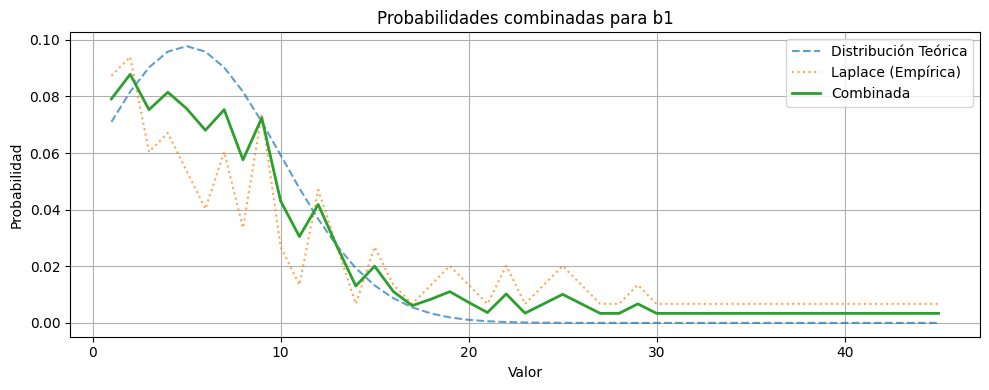

🎯 Siguientes valores más probables para b1:
  2: 0.0878
  4: 0.0815
  1: 0.0791
  5: 0.0757
  3: 0.0753
  7: 0.0753
  9: 0.0724
  6: 0.0680
  8: 0.0576
  10: 0.0431


In [19]:
b1_vals = next_gen_analyze("b1", body_size=104)

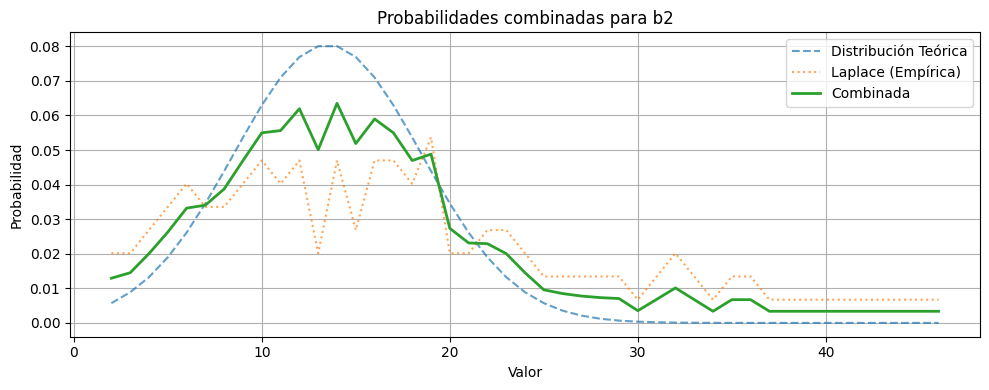

🎯 Siguientes valores más probables para b2:
  14: 0.0635
  12: 0.0619
  16: 0.0590
  11: 0.0556
  10: 0.0550
  17: 0.0550
  15: 0.0519
  13: 0.0501
  19: 0.0488
  9: 0.0470


In [20]:
b2_vals = next_gen_analyze("b2", body_size=104)

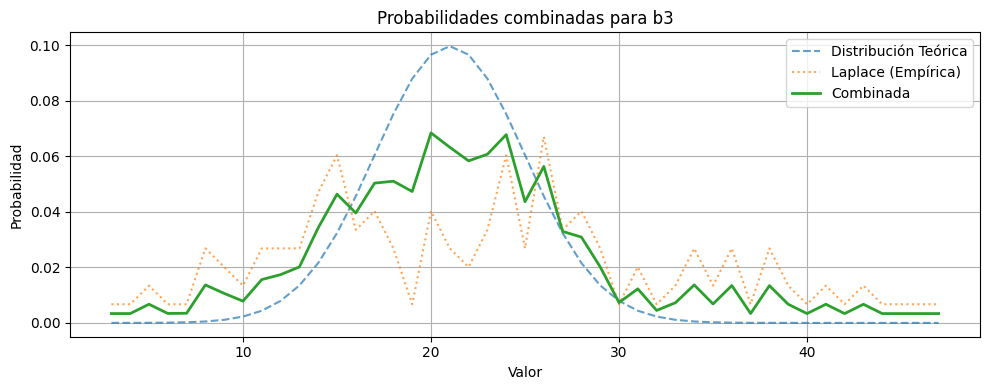

🎯 Siguientes valores más probables para b3:
  20: 0.0685
  24: 0.0678
  21: 0.0633
  23: 0.0608
  22: 0.0584
  26: 0.0564
  18: 0.0511
  17: 0.0504
  19: 0.0474
  15: 0.0464


In [21]:
b3_vals = next_gen_analyze("b3", body_size=104)

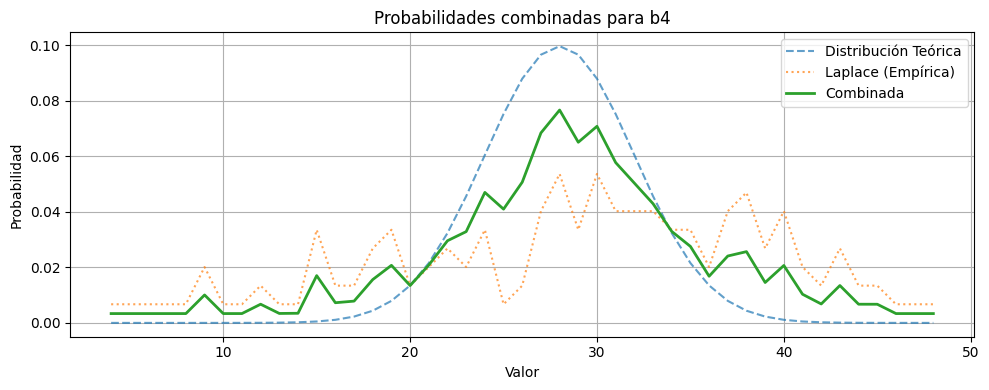

🎯 Siguientes valores más probables para b4:
  28: 0.0767
  30: 0.0709
  27: 0.0685
  29: 0.0651
  31: 0.0578
  26: 0.0507
  32: 0.0504
  24: 0.0470
  33: 0.0430
  25: 0.0410


In [22]:
b4_vals = next_gen_analyze("b4", body_size=104)

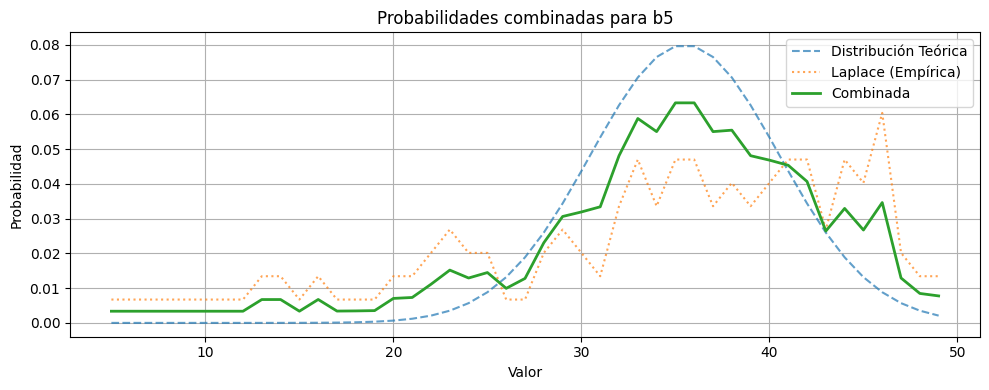

🎯 Siguientes valores más probables para b5:
  35: 0.0633
  36: 0.0633
  33: 0.0588
  38: 0.0554
  34: 0.0550
  37: 0.0550
  32: 0.0481
  39: 0.0481
  40: 0.0468
  41: 0.0453


In [ ]:
b5_vals = next_gen_analyze("b5", body_size=104)

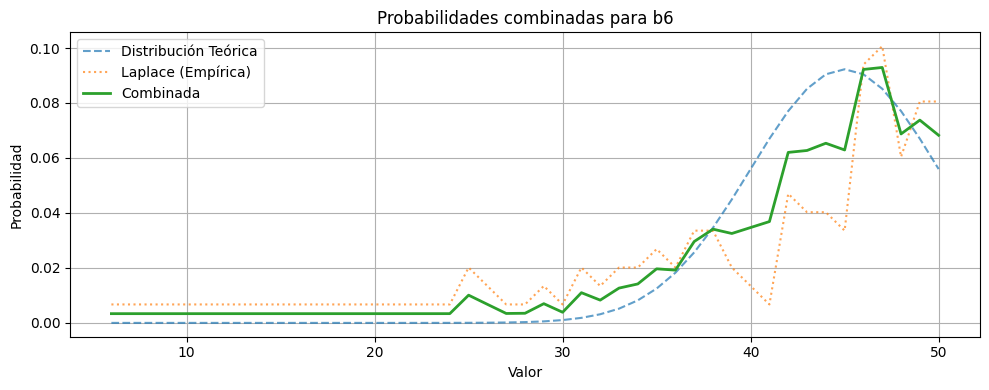

🎯 Siguientes valores más probables para b6:
  47: 0.0929
  46: 0.0922
  49: 0.0738
  48: 0.0687
  50: 0.0683
  44: 0.0654
  45: 0.0629
  43: 0.0627
  42: 0.0620
  41: 0.0369


In [ ]:
b6_vals = next_gen_analyze("b6", body_size=104)